In [96]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools

In [127]:
def read_img(path):
    # opencv read image in BGR color space
    img = cv2.imread(path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img, img_gray

def SIFT(gray_img):
    '''
        Use SIFT to get the keypoint and descriptor of the keypoint

        Args:
            gray_img: SIFT need gray scale image as input
        
        Returns:
            keypoint: The keypoints tuple 
            des: The 128-dim of each keypoint

    '''
    sift_detector = cv2.SIFT_create()
    keypoint, des = sift_detector.detectAndCompute(gray_img, None)
    return keypoint, des

def match_keypoint(kp_left, kp_right, des_left, des_right):
    match = []
    K = 2
    ratio = 0.7

    for i in range(des_left.shape[0]):
        distance = np.linalg.norm(des_left[i] - des_right, axis=1)
        nearest_neighbor_ids = distance.argsort()[:K]
        if (distance[nearest_neighbor_ids[0]] < ratio * distance[nearest_neighbor_ids[1]]):
            match.append([kp_left[i].pt, kp_right[nearest_neighbor_ids[0]].pt])
    
    # The result will have duplicate keypoint but with different descriptor, 
    # but we only interest at keypoiny coordinate to image stitching, so remove duplicate ones.
    remove_dupliacte = []
    remove_dupliacte = sorted(match)
    remove_dupliacte = list(remove_dupliacte for remove_dupliacte, _ in itertools.groupby(remove_dupliacte))
    
    return remove_dupliacte

def homography(pairs):
    """
        solve p1' = H * p1, (H is homograpy matrix we want to get)

        Args: 
            pairs = [[(x1, y1), (x1', y1')], [(x2,y2), (x2', y2')], ...]
            pairs should have at least 4 pairs.
            
    """
    A = []
    for i in range(len(pairs)):
        p1 = pairs[i][0] #(x1, y1)
        p2 = pairs[i][1] #(x1', y1')

        # [x1, y1, 1, 0, 0, 0, -x1'x1, -x1'y1, -x1']
        A.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1], -p2[0]])
        # [0, 0, 0, x1, y1, 1, -y1'x1, -y1'y1, -y1']
        A.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1], -p2[1]])

    # use SVD to solve the linear equation A*H = 0
    # find the smallest number in s and H = corresponding vector in vt
    # np.linalg.svd() will return s in descending order, so we can get the last vector in vt to get H
    u, s, vt = np.linalg.svd(A)
    H = vt[-1].reshape(3, 3)

    # normalize h22 to 1
    H = H/H[2, 2]
    return H


array([[[226, 171, 114],
        [226, 171, 114],
        [226, 171, 114],
        ...,
        [230, 185, 134],
        [229, 184, 133],
        [229, 184, 133]],

       [[228, 173, 116],
        [228, 173, 116],
        [227, 172, 115],
        ...,
        [229, 184, 133],
        [229, 184, 133],
        [229, 184, 133]],

       [[227, 172, 115],
        [228, 173, 116],
        [227, 172, 115],
        ...,
        [229, 184, 133],
        [229, 184, 133],
        [229, 184, 133]],

       ...,

       [[ 53, 109,  90],
        [ 21,  77,  58],
        [ 31,  87,  68],
        ...,
        [ 45,  51,  58],
        [ 46,  50,  55],
        [ 44,  48,  53]],

       [[ 52, 107,  88],
        [ 67, 122, 103],
        [ 79, 134, 115],
        ...,
        [ 29,  32,  40],
        [ 34,  37,  42],
        [ 33,  36,  41]],

       [[ 53, 108,  89],
        [ 50, 105,  86],
        [ 55, 107,  89],
        ...,
        [ 21,  24,  32],
        [ 26,  29,  34],
        [ 33,  36,  41]]

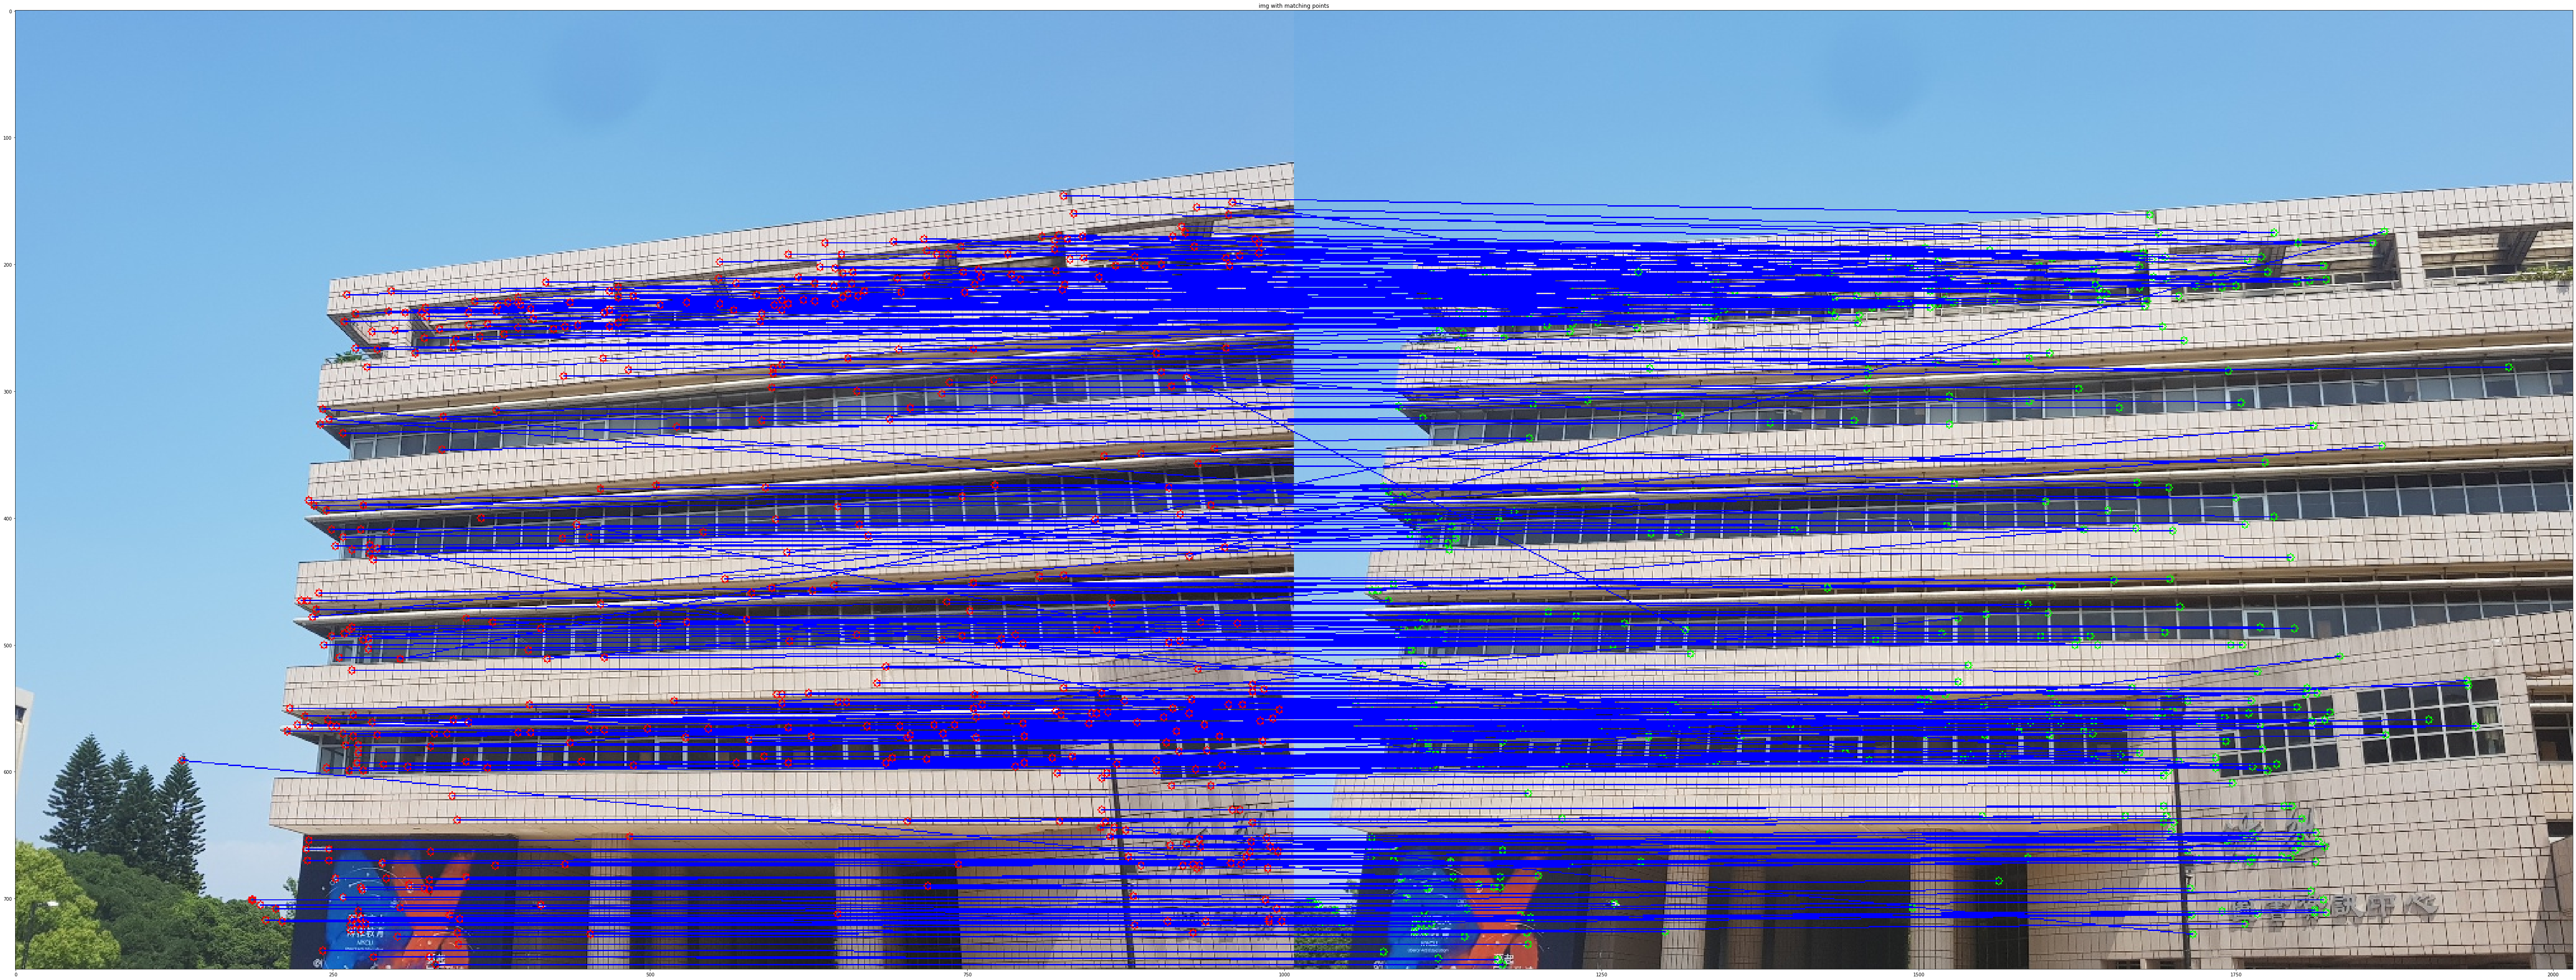

In [92]:
def drawMatches(imgs, matches_pos):
        '''
            Draw the match points img with keypoints and connection line
        '''
        
        # initialize the output visualization image
        img_left, img_right = imgs
        (hl, wl) = img_left.shape[:2]
        (hr, wr) = img_right.shape[:2]
        vis = np.zeros((max(hl, hr), wl + wr, 3), dtype="uint8")
        vis[0:hl, 0:wl] = img_left
        vis[0:hr, wl:] = img_right
        
        # Draw the match
        for (img_left_pos, img_right_pos) in matches_pos:
                pos_l = int(img_left_pos[0]), int(img_left_pos[1])
                pos_r = int(img_right_pos[0]) + wl, int(img_right_pos[1])
                cv2.circle(vis, pos_l, 3, (0, 0, 255), 1)
                cv2.circle(vis, pos_r, 3, (0, 255, 0), 1)
                cv2.line(vis, pos_l, pos_r, (255, 0, 0), 1)
                
        # return the visualization
        plt.figure(figsize=(100, 100))
        plt.title("img with matching points")
        plt.imshow(vis[:,:,::-1])
        #cv2.imwrite("Feature matching img/matching.jpg", vis)
        
        return vis

drawMatches((left_img, right_img), match_point)


In [100]:
left_img, left_img_gray = read_img("./test/m1.jpg")
right_img, right_img_gray = read_img("./test/m2.jpg")

left_kp, left_des = SIFT(left_img_gray)
right_kp, right_des = SIFT(right_img_gray)

match_point = match_keypoint(left_kp, right_kp, left_des, right_des)

TypeError: homography() missing 1 required positional argument: 'p2'

In [128]:
homography(match_point[0:4])

array([[ 6.29176034e-02,  1.14324836e-02, -2.01512381e+01],
       [ 4.48544758e+00, -2.22833819e+00,  7.05346268e+02],
       [ 6.37969904e-03, -3.16483974e-03,  1.00000000e+00]])